<a href="https://colab.research.google.com/github/SMKProj/TransferLearning/blob/main/TransferLearning_on_FlowersDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TRANSFER LEARNING: Classification of tf_flowers dataset using Mobilenet Predeveloped Model**

The following code is a coding exercise for a Machine Learning Program offered in Udacity

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow import keras
from keras import layers

**Splitting Dataset into Training and Validation Datasets**

In [2]:
splits = ['train[:70%]', 'train[70%:]']

(training_set, validation_set), dataset_info = tfds.load('tf_flowers', with_info=True, as_supervised=True, split=splits)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to ~/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


**Printing Information About Training & Validation Datasets**

In [3]:
num_classes = dataset_info.features['label'].num_classes
num_training_examples = dataset_info.splits['train[:70%]'].num_examples
num_validation_examples = dataset_info.splits['train[70%:]'].num_examples

print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 5
Total Number of Training Images: 2569
Total Number of Validation Images: 1101 



**Printing Shapes of 5 Images in Training Dataset **

In [4]:
for i, example in enumerate(training_set.take(5)):
  print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (333, 500, 3) label: 2
Image 2 shape: (212, 320, 3) label: 3
Image 3 shape: (240, 320, 3) label: 3
Image 4 shape: (240, 320, 3) label: 4
Image 5 shape: (317, 500, 3) label: 3


**Since Mobilenet_V2 model only accepts images with 224 x 224 resolution so we have to resize our images**

Following code first resize the images and then create train and validation batches for the model

In [5]:
IMAGE_RES = 224

def format_image(image, label):
  image = tf.image.resize(image, size = (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches = training_set.shuffle(num_training_examples//4 ).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_set.shuffle(num_validation_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

While using Transfer learning, the last output layer of used model like here Mobilenet_v2 will not be used as there is difference of classes.

For the purpose second most layer which is also called feature_extractor layer will be used and trainable value will be set to False

In [6]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,input_shape=(IMAGE_RES,IMAGE_RES,3),)

In [7]:
feature_extractor.trainable = False

**Developing Model**

In [8]:
model = tf.keras.Sequential()
model.add(feature_extractor)
model.add(keras.layers.Dense(5))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [9]:
EPOCHS = 6
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 100s 1s/step - loss: 0.7924 - accuracy: 0.7143 - val_loss: 0.4695 - val_accuracy: 0.8311
Epoch 2/6
81/81 [==============================] - 96s 1s/step - loss: 0.3862 - accuracy: 0.8770 - val_loss: 0.3547 - val_accuracy: 0.8765
Epoch 3/6
81/81 [==============================] - 94s 1s/step - loss: 0.3019 - accuracy: 0.9035 - val_loss: 0.3268 - val_accuracy: 0.8874
Epoch 4/6
81/81 [==============================] - 94s 1s/step - loss: 0.2537 - accuracy: 0.9198 - val_loss: 0.3040 - val_accuracy: 0.8955
Epoch 5/6
81/81 [==============================] - 95s 1s/step - loss: 0.2211 - accuracy: 0.9303 - val_loss: 0.3176 - val_accuracy: 0.8883
Epoch 6/6
81/81 [==============================] - 111s 1s/step - loss: 0.1970 - accuracy: 0.9447 - val_loss: 0.2827 - val_accuracy: 0.9010


**Plotting model accuracy and loss for Training & Validation datasets**

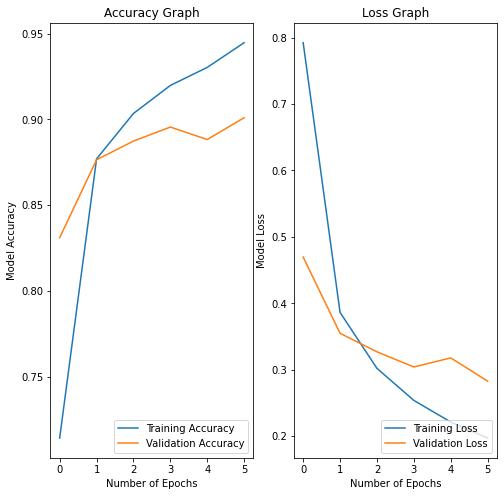

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Number of Epochs')
plt.ylabel('Model Accuracy')
plt.title('Accuracy Graph')

plt.subplot(1,2,2)
plt.plot(epochs_range,loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc='lower right')
plt.xlabel('Number of Epochs')
plt.ylabel('Model Loss')
plt.title('Loss Graph')

plt.show()

**Extracting class names / labels of tf_flowers dataset**

In [11]:
class_names = np.array(dataset_info.features['label'].names)
class_names

array(['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'],
      dtype='<U10')

**Using developed model for predicting classes**

In [12]:
image_batch, label_batch = next(iter(train_batches))

image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

In [13]:
print('Predicted Class Names: ', predicted_class_names)
print('True Labels: ', label_batch )

Predicted Class Names:  ['sunflowers' 'tulips' 'roses' 'sunflowers' 'daisy' 'roses' 'dandelion'
 'tulips' 'dandelion' 'dandelion' 'dandelion' 'daisy' 'sunflowers'
 'tulips' 'dandelion' 'dandelion' 'tulips' 'tulips' 'roses' 'sunflowers'
 'dandelion' 'dandelion' 'daisy' 'daisy' 'dandelion' 'dandelion' 'daisy'
 'dandelion' 'daisy' 'dandelion' 'roses' 'roses']
True Labels:  [3 2 4 3 1 4 4 2 0 0 0 1 3 2 0 0 2 2 4 3 0 0 1 1 0 0 1 0 1 0 4 4]


**Plotting Predicted Class Labels for Images**

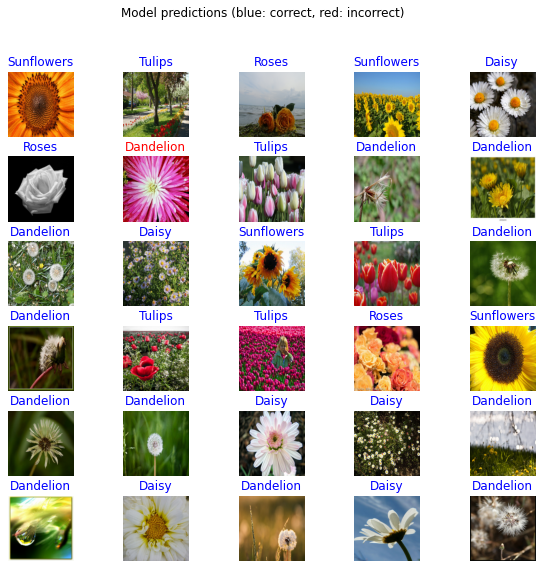

In [14]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")